As houses with facility of solar power generation has different power generation capabilities, it is difficult to forcast the demand. Hence I worked on solarmonthlydata to forecast the future months power requirement. Developed a forcasting model using XGboost and Lightgbm which can forcast power requirement of next 5 months of an individual house.

In [95]:
import pandas as pd
import numpy as np
import datetime as dt

In [97]:
solar_data = pd.read_csv('SolarMonthlyData_2657Custs.csv')
# Data preprocessing
# ======================================================================================
consumption_billrate = ['PK', 'LVP', 'SH', 'LVS','OP','OP1','OP2']
solar_data_consumption = solar_data[(solar_data['Netwk Bill Rate Type'].isin(consumption_billrate)) & (solar_data['Unit of me'] == 'KWH')].copy()
solar_data_consumption['Consumption Month'] = solar_data_consumption['Consumption Month'].apply(lambda x: "{:.4f}".format(x))
solar_data_consumption['Consumption Month'] = solar_data_consumption['Consumption Month'].astype('str')
solar_data_consumption['Consumption Month'] = pd.to_datetime(solar_data_consumption['Consumption Month'].apply(lambda x: dt.datetime.strptime(x, '%m.%Y')))
solar_data_consumption['house_type'] = 'solar'
solar_data_consumption.head()

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me,house_type
96,1,OP1,2007-01-01,168.073,KWH,solar
97,1,OP1,2008-01-01,145.746,KWH,solar
99,1,OP1,2009-01-01,189.888,KWH,solar
101,1,OP1,2010-01-01,163.563,KWH,solar
103,1,OP1,2011-01-01,176.308,KWH,solar


In [98]:
generation_billrate = ['PGR', 'SGR','OGR','OGG','PGG','SGG']
solar_data_generation = solar_data[(solar_data['Netwk Bill Rate Type'].isin(generation_billrate)) & (solar_data['Unit of me'] == 'KWH')].copy()
solar_data_generation['Consumption Month'] = solar_data_generation['Consumption Month'].apply(lambda x: "{:.4f}".format(x))
solar_data_generation['Consumption Month'] = solar_data_generation['Consumption Month'].astype('str')
solar_data_generation['Consumption Month'] = pd.to_datetime(solar_data_generation['Consumption Month'].apply(lambda x: dt.datetime.strptime(x, '%m.%Y')))
#solar_data_generation['house_type'] = 'solar'
solar_data_generation.head()

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me
104,1,OGR,2011-01-01,2.060,KWH
107,1,SGR,2011-01-01,411.840,KWH
109,1,PGR,2011-01-01,131.230,KWH
113,1,OGR,2012-01-01,2.031,KWH
115,1,PGR,2012-01-01,116.147,KWH


In [99]:
solar_grouped_generation  = solar_data_generation.groupby(['Customer ID', 'Consumption Month']).agg({'Sum': 'sum'}).reset_index()
solar_grouped_consumption = solar_data_consumption.groupby(['Customer ID', 'Consumption Month']).agg({'Sum': 'sum'}).reset_index()

In [100]:
solar_grouped_consumption.head()

,Customer ID,Consumption Month,Sum
0,1,2007-01-01,168.073
1,1,2007-02-01,159.667
2,1,2007-03-01,176.774
3,1,2007-04-01,182.439
4,1,2007-05-01,235.507


In [101]:
solar_grouped_data.shape

(138251, 3)

In [102]:
solar_net_consumption = solar_grouped_consumption.merge(solar_grouped_generation, on = [ 'Customer ID', 'Consumption Month'], how = 'left',
          suffixes=('_left', '_right'))
solar_net_consumption.tail()

,Customer ID,Consumption Month,Sum_left,Sum_right
211457,2768,2014-08-01,545.788,244.768
211458,2768,2014-09-01,528.182,236.872
211459,2768,2014-10-01,350.627,348.851
211460,2768,2014-11-01,319.078,348.387
211461,2768,2014-12-01,329.715,360.001


In [103]:
solar_net_consumption['consumption'] = solar_net_consumption.fillna(0)['Sum_left'] - solar_net_consumption.fillna(0)['Sum_right']

In [104]:
solar_net_consumption.drop(['Sum_left','Sum_right'], axis=1, inplace=True)

In [105]:
solar_net_consumption.head()

,Customer ID,Consumption Month,consumption
0,1,2007-01-01,168.073
1,1,2007-02-01,159.667
2,1,2007-03-01,176.774
3,1,2007-04-01,182.439
4,1,2007-05-01,235.507


In [118]:

pivoted_df = solar_net_consumption.pivot(index='Customer ID', columns='Consumption Month', values='consumption')
pivoted_df.reset_index(inplace = True)
pivoted_df.columns = [col.strftime('%Y-%m-%d') if isinstance(col, pd.Timestamp) else col for col in pivoted_df.columns]
columns_to_keep = [col for col in pivoted_df.columns if col == 'Customer ID' or (isinstance(col, str) and col <= '2014-10-01')]
df = pivoted_df[columns_to_keep]
df.head()

,Customer ID,2007-01-01,2007-02-01,2007-03-01,2007-04-01,2007-05-01,2007-06-01,2007-07-01,2007-08-01,2007-09-01,...,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01
0,1,168.073,159.667,176.774,182.439,235.507,227.911,244.400,260.400,252.000,...,18.860,186.340,206.304,221.959,436.814,422.723,403.046,287.044,277.784,250.006
1,2,175.188,138.478,153.315,192.666,234.090,226.538,205.087,187.685,181.630,...,717.111,647.950,717.375,689.266,719.113,695.916,717.323,715.776,692.688,346.343
2,3,118.287,93.906,103.967,132.050,158.108,153.007,161.606,163.261,157.995,...,28.943,38.083,42.163,197.961,298.577,288.943,394.239,446.832,432.418,187.381
3,4,138.152,144.273,166.923,161.538,218.116,231.346,240.459,218.383,206.211,...,46.430,19.470,2.483,3.726,18.889,27.472,28.403,28.903,28.370,29.316
4,6,347.032,304.376,337.371,337.582,348.835,339.330,433.333,433.333,419.355,...,587.600,497.734,551.062,719.703,750.334,726.131,869.478,877.661,849.349,56.622


In [119]:
df.columns

Index(['Customer ID', '2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
       '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01', '2007-09-01',
       '2007-10-01', '2007-11-01', '2007-12-01', '2008-01-01', '2008-02-01',
       '2008-03-01', '2008-04-01', '2008-05-01', '2008-06-01', '2008-07-01',
       '2008-08-01', '2008-09-01', '2008-10-01', '2008-11-01', '2008-12-01',
       '2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01', '2009-05-01',
       '2009-06-01', '2009-07-01', '2009-08-01', '2009-09-01', '2009-10-01',
       '2009-11-01', '2009-12-01', '2010-01-01', '2010-02-01', '2010-03-01',
       '2010-04-01', '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
       '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01', '2011-01-01',
       '2011-02-01', '2011-03-01', '2011-04-01', '2011-05-01', '2011-06-01',
       '2011-07-01', '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01',
       '2011-12-01', '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01'

In [123]:
df = df.fillna(0)

In [124]:
df.head()

,Customer ID,2007-01-01,2007-02-01,2007-03-01,2007-04-01,2007-05-01,2007-06-01,2007-07-01,2007-08-01,2007-09-01,...,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01
0,1,168.073,159.667,176.774,182.439,235.507,227.911,244.400,260.400,252.000,...,18.860,186.340,206.304,221.959,436.814,422.723,403.046,287.044,277.784,250.006
1,2,175.188,138.478,153.315,192.666,234.090,226.538,205.087,187.685,181.630,...,717.111,647.950,717.375,689.266,719.113,695.916,717.323,715.776,692.688,346.343
2,3,118.287,93.906,103.967,132.050,158.108,153.007,161.606,163.261,157.995,...,28.943,38.083,42.163,197.961,298.577,288.943,394.239,446.832,432.418,187.381
3,4,138.152,144.273,166.923,161.538,218.116,231.346,240.459,218.383,206.211,...,46.430,19.470,2.483,3.726,18.889,27.472,28.403,28.903,28.370,29.316
4,6,347.032,304.376,337.371,337.582,348.835,339.330,433.333,433.333,419.355,...,587.600,497.734,551.062,719.703,750.334,726.131,869.478,877.661,849.349,56.622


In [159]:
# splitting the data 
import pandas as pd
from sklearn.model_selection import train_test_split


X = df.iloc[:, :-5]  # Features are all columns except the last 5
y = df.iloc[:, -5:]  # Target variables are the last 5 columns


train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
test_size = len(df) - train_size - val_size

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=val_size+test_size, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size, shuffle=False)

# Verify the shapes of the splits
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2099, 90)
X_val shape: (262, 90)
X_test shape: (263, 90)
y_train shape: (2099, 5)
y_val shape: (262, 5)
y_test shape: (263, 5)


In [160]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the parameters for XGBoost
# tunned the hyperparameters 
params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse', 
    'eta': 0.1,  
    'max_depth': 6,  
    'subsample': 0.8,  
    'colsample_bytree': 0.8  
}



# Convert data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# Train the model
num_rounds = 100  # Number of boosting rounds
xgb_model = xgb.train(params, dtrain, num_rounds, evals=[(dval, 'validation')], early_stopping_rounds=10)

# Make predictions
predictions = xgb_model.predict(dtest)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)


[0]	validation-rmse:398.60271
[1]	validation-rmse:369.75700
[2]	validation-rmse:343.83775
[3]	validation-rmse:321.56856
[4]	validation-rmse:303.21077
[5]	validation-rmse:285.53655
[6]	validation-rmse:269.91625
[7]	validation-rmse:256.77974
[8]	validation-rmse:244.64850
[9]	validation-rmse:235.59614
[10]	validation-rmse:226.56708
[11]	validation-rmse:218.51671
[12]	validation-rmse:211.48268
[13]	validation-rmse:206.13357
[14]	validation-rmse:201.82297
[15]	validation-rmse:197.14138
[16]	validation-rmse:193.44413
[17]	validation-rmse:190.13336
[18]	validation-rmse:187.31302
[19]	validation-rmse:184.77974
[20]	validation-rmse:182.63319
[21]	validation-rmse:180.71849
[22]	validation-rmse:179.39381
[23]	validation-rmse:177.90338
[24]	validation-rmse:176.41893
[25]	validation-rmse:175.11334
[26]	validation-rmse:174.20791
[27]	validation-rmse:173.51821
[28]	validation-rmse:172.51027
[29]	validation-rmse:172.07723
[30]	validation-rmse:171.44452
[31]	validation-rmse:171.37191
[32]	validation-rm

In [161]:
predictions.shape

(263, 5)

In [162]:
y_test

,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01
2361,0.000,0.000,0.000,0.000,0.000
2362,323.121,487.429,487.429,463.519,233.696
2363,14.866,10.456,10.456,-31.163,-80.956
2364,328.271,338.210,338.210,286.232,277.584
2365,324.554,397.072,418.503,405.002,445.224
...,...,...,...,...,...
2619,273.956,531.274,548.383,530.693,142.873
2620,352.835,394.762,407.074,393.944,359.834
2621,311.293,321.710,235.038,227.456,230.344
2622,373.448,385.940,253.702,245.519,251.521


In [156]:
predictions 

array([[  5.633308 ,   4.001099 ,  11.926993 , ...,  59.140686 ,
         19.983723 ,   1.2709241],
       [309.20242  , 297.56717  , 341.98138  , ..., 509.7868   ,
        466.97876  , 334.71097  ],
       [-25.17656  , -11.29662  ,   8.213502 , ..., 130.7835   ,
         65.47344  , -28.85831  ],
       ...,
       [159.02467  , 152.49358  , 195.8066   , ..., 271.5642   ,
        271.08786  , 227.47562  ],
       [237.09808  , 226.26836  , 274.76404  , ..., 415.307    ,
        421.6251   , 284.30432  ],
       [-20.54385  , -27.999466 ,  53.850246 , ..., 221.35556  ,
        314.11215  , -34.786694 ]], dtype=float32)

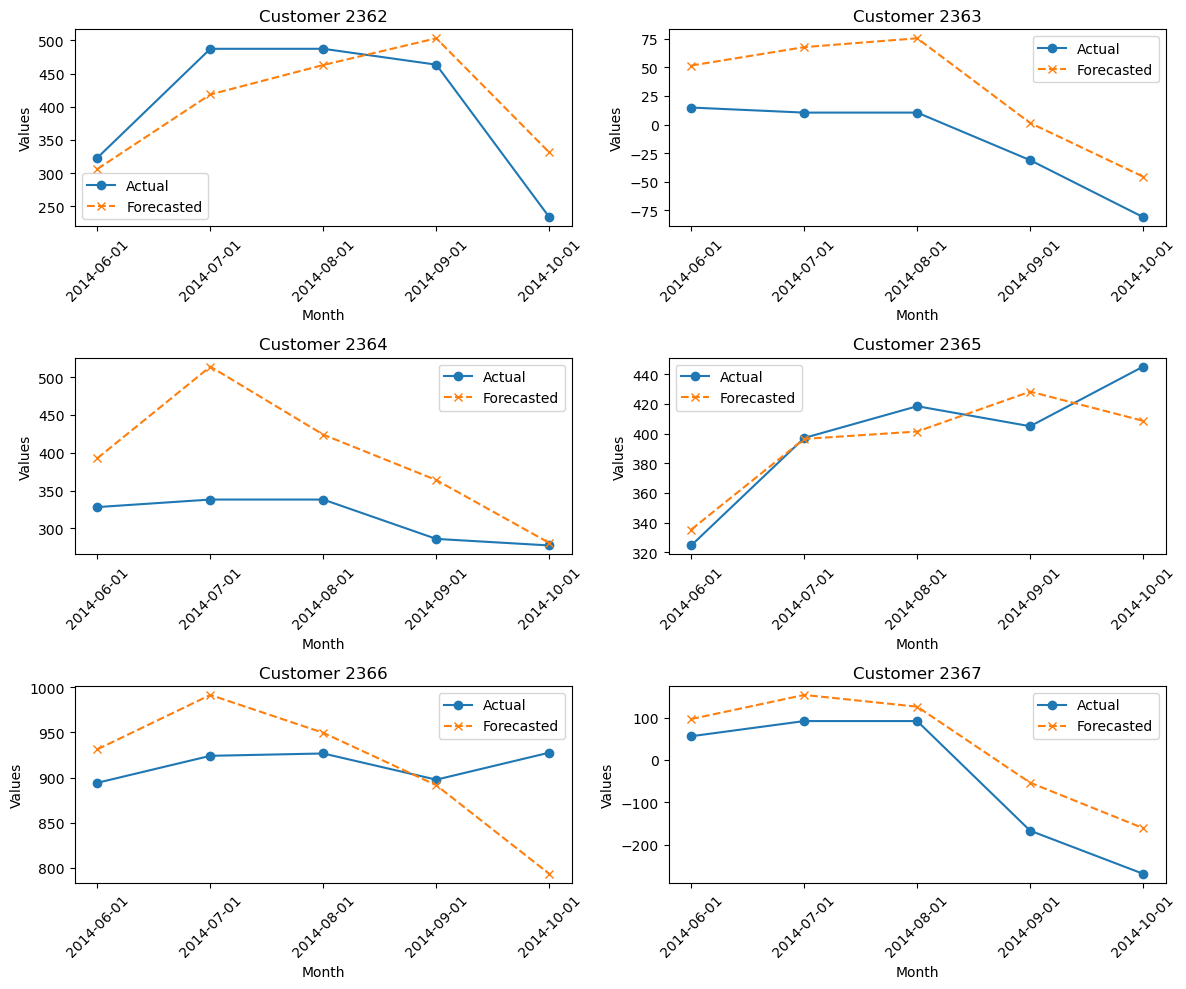

In [163]:
import matplotlib.pyplot as plt

# Data
actual_data = y_test.loc[2362:2368].values
forecasted_data = predictions[1:7]
dates = ['2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01']

# Plot
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

for i in range(3):  # Three rows
    for j in range(2):  # Two plots per row
        idx = i * 2 + j
        axs[i, j].plot(dates, actual_data[idx], label='Actual', marker='o')
        axs[i, j].plot(dates, forecasted_data[idx], label='Forecasted', linestyle='--', marker='x')
        axs[i, j].set_xlabel('Month')
        axs[i, j].set_ylabel('Values')
        axs[i, j].set_title(f'Customer {idx + 2362}')
        axs[i, j].tick_params(axis='x', rotation=45)
        axs[i, j].legend()

plt.tight_layout()
plt.show()


In [157]:
y_test.columns


Index(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
       '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01'],
      dtype='object')

#  Lightgbm

In [176]:
!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/e1/4c/4685ccfae9806f561de716e32549190c1f533dde5bcadaf83bdf23972cf0/lightgbm-4.3.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB 660.6 kB/s eta 0:00:02
    --------------------------------------- 0.0/1.3 MB 660.6 kB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.3 MB 1.1 MB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.3 MB 1.4 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.3 MB 1.6 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.3 MB 1.8 MB/s eta 0:00:01
   ------------------ --------------------- 0.6/1.3 MB 2.0 MB/s eta 0:00:01
   ---------------------- ----------------- 0.8/1.3 MB 2.1 MB/s eta 0:00:01
   -------------------------- -------------

In [182]:
# splitting the data 
import pandas as pd
from sklearn.model_selection import train_test_split


X = df.iloc[:, :-1]  # Features are all columns except the last 5
y = df.iloc[:, -1:]  # Target variables are the last 5 columns


train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
test_size = len(df) - train_size - val_size

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=val_size+test_size, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size, shuffle=False)

# Verify the shapes of the splits
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2099, 94)
X_val shape: (262, 94)
X_test shape: (263, 94)
y_train shape: (2099, 1)
y_val shape: (262, 1)
y_test shape: (263, 1)


In [185]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'num_leaves': 10,
    'colsample_bytree': 0.8
}

# Convert data into LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Train the model
num_rounds = 100  # Number of boosting rounds
lgb_model = lgb.train(params, train_data, num_rounds, valid_sets=[val_data])

# Make predictions
predictions = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23970
[LightGBM] [Info] Number of data points in the train set: 2099, number of used features: 94
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 346.806976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po